# Multi-Agent PPO for Warehouse Task Allocation

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Environment


## 1. Overview
The **WarehouseTaskAllocationEnv** simulates a multi-agent logistics scenario involving **1 Dispatcher** and **2 Acceptors** (Processing Stations). The goal is to efficiently route incoming jobs to stations to maximize throughput while minimizing queue congestion and wait times.

This is a **Stochastic**, **Finite-Horizon**, **Partially-Automated** resource allocation environment.

## 2. Technical Specifications

| Feature | Type | Description |
| :--- | :--- | :--- |
| **Dynamics** | **Stochastic** | Job arrivals (Bernoulli process) and processing times (Uniform random) are probabilistic. |
| **Observation Space** | **Continuous (Box)** | A 7-dimensional vector representing queue lengths, processing loads, and job status. |
| **Action Space** | **Composite / Dictionary** | Requires simultaneous decisions for the Dispatcher and both Station Acceptors. |
| **Episodic** | **Yes** | Fixed episode length of `50` time steps. |
| **State Visibility** | **Fully Observable** | The agent perceives the global state of queues and processing units. |

## 3. Observation Space
The observation is a normalized `Box(7,)` vector containing:
1.  **Station 0 Queue Length** (Current waiting jobs)
2.  **Station 0 Processing Count** (Active jobs)
3.  **Station 0 Avg Remaining Time** (Workload estimate)
4.  **Station 1 Queue Length**
5.  **Station 1 Processing Count**
6.  **Station 1 Avg Remaining Time**
7.  **Pending Job Flag** (1.0 if a new job is waiting assignment, else 0.0)

## 4. Action Space
The environment expects a Dictionary of actions at every step:
* **Dispatcher (Discrete 3):**
    * `0`: Attempt route to Station 0.
    * `1`: Attempt route to Station 1.
    * `2`: Reject Job / No Action.
* **Acceptor 0 & 1 (Discrete 2):**
    * `0`: Reject incoming transfer.
    * `1`: Accept incoming transfer.

> **Note:** A job is only successfully enqueued if the Dispatcher sends it *and* the specific Station Acceptor accepts it.

## 5. Reward Function Logic
The agent learns via a dense reward signal designed to encourage high throughput and load balancing:

###  Positive Rewards (Gains)
* **+1.0**: Job successfully added to a queue.
* **+10.0**: Job finishes processing (Throughput).
* **+0.5**: Load Balancing Bonus (awarded if routing to the shorter of the two queues).

###  Negative Rewards (Penalties)
* **-2.0**: Dispatcher rejects a pending job.
* **-2.0**: Acceptor rejects a routed job.
* **-5.0**: Routing failed due to full queue (Capacity Reached).
* **Congestion Penalty**: If queue length > 70% max capacity, penalty = `length * 0.8`.
* **Imbalance Penalty**: If `|Queue_0 - Queue_1| > 2`, penalty = `0.3 * difference`.

## 6. System Dynamics
* **Arrivals:** New jobs arrive with probability $\epsilon = 0.7$ per step.
* **Processing:** Jobs take between 1 and 5 steps to complete (Randomized upon creation).
* **Constraints:** Each station has a max queue length of 10 and max concurrent processing capacity of 2.


In [ ]:

# ============================================================
# ENVIRONMENT
# ============================================================

class WarehouseTaskAllocationEnv(gym.Env):
    """
    Multi-Agent Warehouse Environment
    Architecture: 1 Dispatcher + 2 Acceptors (one per station)
    """

    def __init__(self):
        super().__init__()

        # === BASIC PARAMETERS ===
        self.num_stations = 2
        self.max_queue_length = 10
        self.max_processing_time = 5
        self.station_capacity = 2
        self.arrival_rate = 0.7
        self.episode_length = 50

        # === TRACKING VARIABLES ===
        self.current_step = None
        self.station_queues = None
        self.station_processing = None
        self.pending_job = None

        # === METRICS ===
        self.total_jobs_arrived = 0
        self.total_jobs_completed = 0
        self.total_jobs_rejected = 0
        self.wait_times = []

        print("✓ Environment initialized!")
        print(f"  Architecture: 1 Dispatcher + {self.num_stations} Acceptors")

        # === DEFINE SPACES ===
        obs_dim = self.num_stations * 3 + 1
        self.observation_space = spaces.Box(
            low=0,
            high=max(self.max_queue_length, self.max_processing_time, self.station_capacity),
            shape=(obs_dim,),
            dtype=np.float32
        )

        self.dispatcher_action_space = spaces.Discrete(self.num_stations + 1)
        self.acceptor_action_space = spaces.Discrete(2)

        print(f"   Observation space: {self.observation_space.shape}")
        print(f"   Dispatcher: {self.dispatcher_action_space.n} actions")
        print(f"   Each Acceptor: {self.acceptor_action_space.n} actions")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)

        self.station_queues = [deque() for _ in range(self.num_stations)]
        self.station_processing = [[] for _ in range(self.num_stations)]

        self.current_step = 0
        self.pending_job = None

        self.total_jobs_arrived = 0
        self.total_jobs_completed = 0
        self.total_jobs_rejected = 0
        self.wait_times = []

        if np.random.random() < self.arrival_rate:
            self._generate_job()

        observation = self._get_observation()
        info = self._get_info()

        return observation, info

    def step(self, actions):
        dispatcher_action = actions['dispatcher']
        acceptor_0_action = actions['acceptor_0']
        acceptor_1_action = actions['acceptor_1']

        reward = 0

        # STEP 1: Route pending job
        if self.pending_job is not None:
            if dispatcher_action >= self.num_stations:
                self.total_jobs_rejected += 1
                self.pending_job = None
                reward -= 2
            else:
                target_station = dispatcher_action

                if target_station == 0:
                    acceptor_decision = acceptor_0_action
                else:
                    acceptor_decision = acceptor_1_action

                if acceptor_decision == 1:
                    if len(self.station_queues[target_station]) < self.max_queue_length:
                        self.station_queues[target_station].append(self.pending_job)
                        self.pending_job = None
                        reward += 1

                        # === LOAD BALANCING: Bonus for routing to shorter queue ===
                        other_station = 1 - target_station
                        if len(self.station_queues[target_station]) <= len(self.station_queues[other_station]):
                            reward += 0.5  # Bonus for good routing decision

                    else:
                        self.total_jobs_rejected += 1
                        self.pending_job = None
                        reward -= 5
                else:
                    self.total_jobs_rejected += 1
                    self.pending_job = None
                    reward -= 2

        # STEP 2: Process jobs
        for station_idx in range(self.num_stations):
            while (len(self.station_processing[station_idx]) < self.station_capacity and
                  len(self.station_queues[station_idx]) > 0):
                job = self.station_queues[station_idx].popleft()
                job['remaining_time'] = job['processing_time']
                job['start_processing_time'] = self.current_step
                self.station_processing[station_idx].append(job)

            completed_jobs = []
            for job in self.station_processing[station_idx]:
                job['remaining_time'] -= 1

                if job['remaining_time'] <= 0:
                    completed_jobs.append(job)
                    wait_time = job['start_processing_time'] - job['arrival_time']
                    self.wait_times.append(wait_time)
                    self.total_jobs_completed += 1
                    reward += 10

            for job in completed_jobs:
                self.station_processing[station_idx].remove(job)

        # STEP 3: Penalize congestion
        for station_idx in range(self.num_stations):
            queue_len = len(self.station_queues[station_idx])
            if queue_len > 0.7 * self.max_queue_length:
                penalty = queue_len * 0.8
                reward -= penalty

        # === STEP 3.5: Penalize queue imbalance ===
        q0, q1 = len(self.station_queues[0]), len(self.station_queues[1])
        queue_diff = abs(q0 - q1)
        if queue_diff > 2:
            reward -= 0.3 * queue_diff

        # STEP 4: Generate new job
        if np.random.random() < self.arrival_rate:
            self._generate_job()

        # STEP 5: Increment time
        self.current_step += 1

        # STEP 6: Check termination
        terminated = False
        truncated = self.current_step >= self.episode_length

        observation = self._get_observation()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def _generate_job(self):
        job = {
            'id': self.total_jobs_arrived,
            'processing_time': np.random.randint(1, self.max_processing_time + 1),
            'remaining_time': None,
            'arrival_time': self.current_step,
            'start_processing_time': None,
        }

        self.pending_job = job
        self.total_jobs_arrived += 1

    def _get_observation(self):
        obs = []

        for i in range(self.num_stations):
            queue_len = len(self.station_queues[i])
            num_processing = len(self.station_processing[i])

            if self.station_processing[i]:
                avg_remaining = np.mean([job['remaining_time']
                                        for job in self.station_processing[i]])
            else:
                avg_remaining = 0

            obs.extend([queue_len, num_processing, avg_remaining])

        pending_flag = 1 if self.pending_job is not None else 0
        obs.append(pending_flag)

        return np.array(obs, dtype=np.float32)

    def _get_info(self):
        return {
            'current_step': self.current_step,
            'total_jobs_arrived': self.total_jobs_arrived,
            'total_jobs_completed': self.total_jobs_completed,
            'total_jobs_rejected': self.total_jobs_rejected,
            'queue_lengths': [len(q) for q in self.station_queues],
            'avg_wait_time': np.mean(self.wait_times) if self.wait_times else 0,
        }

# === BASELINE POLICIES ===

    def get_shortest_queue_action(self):
        """Route to shortest queue"""
        if self.pending_job is None:
            return {'dispatcher': self.num_stations, 'acceptor_0': 0, 'acceptor_1': 0}

        queue_lengths = [len(q) for q in self.station_queues]
        shortest_station = np.argmin(queue_lengths)

        if queue_lengths[shortest_station] >= self.max_queue_length:
            return {'dispatcher': self.num_stations, 'acceptor_0': 0, 'acceptor_1': 0}

        return {'dispatcher': shortest_station, 'acceptor_0': 1, 'acceptor_1': 1}

    def get_random_action(self):
        """Random policy"""
        return {
            'dispatcher': np.random.randint(0, self.num_stations + 1),
            'acceptor_0': np.random.randint(0, 2),
            'acceptor_1': np.random.randint(0, 2)
        }



In [ ]:

# ============================================================
# TEST CODE
# ============================================================

print("\n" + "="*60)
print("  TESTING WAREHOUSE ENVIRONMENT")
print("="*60 + "\n")

env = WarehouseTaskAllocationEnv()

print("\n--- Test: Run 10 steps with Shortest Queue policy ---\n")

obs, info = env.reset(seed=42)
total_reward = 0

for step in range(10):
    action = env.get_shortest_queue_action()

    print(f"Step {step+1}: Queues={info['queue_lengths']}, "
          f"Action=Sta{action['dispatcher']}")

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    print(f"  → Reward={reward:.0f}, Completed={info['total_jobs_completed']}")

    if terminated or truncated:
        break

print(f"\n{'='*60}")
print(f"TOTAL REWARD: {total_reward:.0f}")
print(f"Jobs Completed: {info['total_jobs_completed']}")
print(f"Jobs Rejected: {info['total_jobs_rejected']}")
print(f"{'='*60}\n")


  TESTING WAREHOUSE ENVIRONMENT

✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions

--- Test: Run 10 steps with Shortest Queue policy ---

Step 1: Queues=[0, 0], Action=Sta0
  → Reward=1, Completed=0
Step 2: Queues=[0, 0], Action=Sta0
  → Reward=1, Completed=0
Step 3: Queues=[0, 0], Action=Sta0
  → Reward=1, Completed=0
Step 4: Queues=[1, 0], Action=Sta1
  → Reward=2, Completed=0
Step 5: Queues=[1, 0], Action=Sta1
  → Reward=12, Completed=1
Step 6: Queues=[1, 0], Action=Sta1
  → Reward=22, Completed=3
Step 7: Queues=[0, 1], Action=Sta0
  → Reward=12, Completed=4
Step 8: Queues=[0, 0], Action=Sta2
  → Reward=10, Completed=5
Step 9: Queues=[0, 0], Action=Sta2
  → Reward=20, Completed=7
Step 10: Queues=[0, 0], Action=Sta0
  → Reward=1, Completed=7

TOTAL REWARD: 80
Jobs Completed: 7
Jobs Rejected: 0



# Algorithm 1 : Tabular Q learning

In [ ]:
import numpy as np
from collections import defaultdict

# ----- joint action helpers -----
def enumerate_joint_actions(env):
    D = env.dispatcher_action_space.n          # 3 (0,1,2 where 2==reject)
    A = env.acceptor_action_space.n            # 2 (0,1 = reject,accept)
    joint = []
    for d in range(D):
        for a0 in range(A):
            for a1 in range(A):
                joint.append((d, a0, a1))
    return joint

def joint_id_to_dict(joint, idx):
    d, a0, a1 = joint[idx]
    return {"dispatcher": d, "acceptor_0": a0, "acceptor_1": a1}

# ----- discretizer tailored to your env ranges -----
def discretize_obs(obs, max_q, max_proc, cap):
    # obs = [q0, inproc0, avgrem0, q1, inproc1, avgrem1, pending]
    q0  = int(np.clip(round(obs[0]), 0, max_q))
    ip0 = int(np.clip(round(obs[1]), 0, cap))
    ar0 = int(np.clip(round(obs[2]), 0, max_proc))
    q1  = int(np.clip(round(obs[3]), 0, max_q))
    ip1 = int(np.clip(round(obs[4]), 0, cap))
    ar1 = int(np.clip(round(obs[5]), 0, max_proc))
    pend= int(np.clip(round(obs[6]), 0, 1))
    return (q0, ip0, ar0, q1, ip1, ar1, pend)

class CentralizedQLearner:
    def __init__(self, n_actions, alpha=0.2, gamma=0.99,
                 eps_start=1.0, eps_end=0.05, eps_decay=0.995):
        self.Q = defaultdict(lambda: np.zeros(n_actions, dtype=np.float32))
        self.alpha = alpha
        self.gamma = gamma
        self.eps   = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def select_action(self, s_key, n_actions):
        if np.random.rand() < self.eps:
            return np.random.randint(n_actions)
        return int(np.argmax(self.Q[s_key]))

    def update(self, s, a, r, s2, done):
        q = self.Q[s]
        if done:
            target = r
        else:
            target = r + self.gamma * np.max(self.Q[s2])
        q[a] += self.alpha * (target - q[a])

    def decay_eps(self):
        self.eps = max(self.eps_end, self.eps * self.eps_decay)

def train_q(env, episodes=250, alpha=0.2, gamma=0.99,
            eps_start=1.0, eps_end=0.05, eps_decay=0.995, seed=42):
    np.random.seed(seed)
    JOINT = enumerate_joint_actions(env)
    A = len(JOINT)
    agent = CentralizedQLearner(A, alpha, gamma, eps_start, eps_end, eps_decay)
    returns = []
    completions = []

    for ep in range(episodes):
        obs, info = env.reset(seed=seed+ep)
        s = discretize_obs(obs, env.max_queue_length, env.max_processing_time, env.station_capacity)
        ep_ret = 0.0
        completed_start = info["total_jobs_completed"]

        while True:
            a = agent.select_action(s, A)
            obs2, r, terminated, truncated, info = env.step(joint_id_to_dict(JOINT, a))
            s2 = discretize_obs(obs2, env.max_queue_length, env.max_processing_time, env.station_capacity)

            agent.update(s, a, r, s2, done=(terminated or truncated))
            ep_ret += r
            s = s2
            if terminated or truncated:
                break

        agent.decay_eps()
        returns.append(ep_ret)
        completions.append(info["total_jobs_completed"] - completed_start)

        if (ep+1) % 20 == 0:
            print(f"Ep {ep+1}/{episodes} | Return={ep_ret:.1f} | Completed={completions[-1]} | eps={agent.eps:.3f}")

    return agent, returns, completions

def eval_greedy(env, agent, episodes=5, seed=777):
    JOINT = enumerate_joint_actions(env)
    A = len(JOINT)
    greedy_returns, greedy_completed = [], []
    for ep in range(episodes):
        obs, info = env.reset(seed=seed+ep)
        s = discretize_obs(obs, env.max_queue_length, env.max_processing_time, env.station_capacity)
        ep_ret = 0.0
        completed_start = info["total_jobs_completed"]
        while True:
            # greedy pick
            a = int(np.argmax(agent.Q[s]))
            obs2, r, terminated, truncated, info = env.step(joint_id_to_dict(JOINT, a))
            s = discretize_obs(obs2, env.max_queue_length, env.max_processing_time, env.station_capacity)
            ep_ret += r
            if terminated or truncated:
                break
        greedy_returns.append(ep_ret)
        greedy_completed.append(info["total_jobs_completed"] - completed_start)
    print(f"[Eval] Returns per episode: {greedy_returns}")
    print(f"[Eval] Jobs completed per episode: {greedy_completed}")
    return greedy_returns, greedy_completed


Q learning Training :

In [ ]:
# ----- usage -----
env = WarehouseTaskAllocationEnv()
agent, rets, comps = train_q(env, episodes=500)
eval_greedy(env, agent, episodes=5)

✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions
Ep 20/500 | Return=162.0 | Completed=17 | eps=0.905
Ep 40/500 | Return=75.0 | Completed=11 | eps=0.818
Ep 60/500 | Return=123.0 | Completed=14 | eps=0.740
Ep 80/500 | Return=54.0 | Completed=8 | eps=0.670
Ep 100/500 | Return=159.0 | Completed=18 | eps=0.606
Ep 120/500 | Return=103.0 | Completed=13 | eps=0.548
Ep 140/500 | Return=86.0 | Completed=12 | eps=0.496
Ep 160/500 | Return=214.0 | Completed=21 | eps=0.448
Ep 180/500 | Return=90.0 | Completed=12 | eps=0.406
Ep 200/500 | Return=183.0 | Completed=20 | eps=0.367
Ep 220/500 | Return=162.0 | Completed=17 | eps=0.332
Ep 240/500 | Return=191.0 | Completed=20 | eps=0.300
Ep 260/500 | Return=113.0 | Completed=14 | eps=0.272
Ep 280/500 | Return=172.0 | Completed=18 | eps=0.246
Ep 300/500 | Return=86.0 | Completed=12 | eps=0.222
Ep 320/500 | Return=206.0 | Completed=21 | eps=0.201
Ep 340/500 |

([208.0, 184.0, 215.0, 194.0, 183.0], [21, 20, 22, 20, 20])

# Algorithm 2 : Deep Q Network

###   Masked Deep Q-Network (DQN)

**Goal.** Replace the tabular Q-table with a neural network that can handle the **continuous 7-D state** while still respecting **feasibility constraints** on joint actions.

---

#### 1. Q-Network Architecture

We use a fully-connected network to approximate the action-value function:

\[
Q_\theta(s,a) \approx Q^\*(s,a)
\]

- **Input:** 7-dimensional state  

  \[
  [q_0,\ \text{inproc}_0,\ \text{avg\_rem}_0,\ q_1,\ \text{inproc}_1,\ \text{avg\_rem}_1,\ \text{pending}]
  \]

- **Output:** 12 Q-values, one for each **joint action**  
  (3 dispatcher actions × 2 acceptor\_0 actions × 2 acceptor\_1 actions).
- **Architecture:**  
  \[
  7 \rightarrow 128 \rightarrow 128 \rightarrow 128 \rightarrow 12
  \]
  with ReLU activations.

---

#### 2. Action Masking

The joint action space contains invalid combinations, e.g.:

- Routing a job when **no job is pending**.
- Accepting into a station whose **queue is already full**.

To avoid learning from physically impossible actions, we compute a **binary mask**  

\[
\mathbf{m}(s) \in \{0,1\}^{12}
\]

using the environment state:

- \(m_i = 1\): action \(i\) is feasible.  
- \(m_i = 0\): action \(i\) is invalid and is ignored.

This mask is used in two places:

1. **Action selection (\(\varepsilon\)-greedy):**

   - Exploration: sample uniformly from actions with \(m_i = 1\).  
   - Exploitation: set \(Q(s,a) = -\infty\) for masked actions and take \(\arg\max_a Q(s,a)\).

2. **Target computation:** when computing \(\max_{a'} Q_{\text{target}}(s', a')\), we only maximize over actions with \(m_i = 1\) in the next state.

This dramatically reduces wasted exploration and stabilizes learning.

---

#### 3. DQN Update

For each sampled transition  
\((s, a, r, s', \text{done}, m(s), m(s'))\)  
from the replay buffer, we compute:

\[
y = r + \gamma \max_{a' \,:\, m(s')_{a'} = 1} Q_{\text{target}}(s', a')
\]

\[
L(\theta) = \Big( y - Q_\theta(s, a) \Big)^2
\]

We minimize \(L(\theta)\) using Adam, with:

- Discount factor: \(\gamma = 0.99\)  
- Learning rate: \(5 \times 10^{-4}\)  
- Batch size: 64  
- Target network update every 10 episodes  
- Gradient clipping with \(\lVert \nabla_\theta \rVert \leq 10\)

Exploration uses an \(\varepsilon\)-greedy policy:

- \(\varepsilon\) starts at **1.0** and decays by **0.995** each episode  
- Lower-bounded at \(\varepsilon_{\min} = 0.05\)

---

#### 4. Training Dynamics and Results

Over **500 episodes**:

- **Training rewards** increase and stabilize around a moving average of ~320.  
- **Jobs completed per episode** rise from ~14 to about **29–30 jobs**.  
- \(\varepsilon\) decays smoothly from 1.0 to ~0.08, shifting from exploration to exploitation.

Final performance:

- **Tabular Q-Learning baseline:** ~20–21 jobs/episode  
- **Masked DQN (last 50 episodes):** **29.4 jobs/episode**  
- **Greedy evaluation (10 episodes):**
  - Avg reward: **330.1 ± 25.1**
  - Avg jobs completed: **30.0 ± 2.3**

> **Conclusion:** The masked DQN significantly outperforms the centralized tabular baseline by learning a better policy in the continuous state space, while action masking ensures that exploration and value updates remain restricted to physically feasible joint actions.


In [ ]:

!pip install gymnasium
!pip install matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import pickle

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class WarehouseQNetwork(nn.Module):
    """
    Q-Network for continuous state space (warehouse environment).
    Takes 7D state vector and outputs Q-values for 12 joint actions.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(WarehouseQNetwork, self).__init__()

        # For continuous states, use Linear layer (not Embedding)
        self.fc_input = nn.Linear(state_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        """
        state: (batch_size, state_dim) - continuous vector
        returns: (batch_size, action_dim) - Q-values
        """
        x = F.relu(self.fc_input(state))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_values = self.fc_output(x)
        return q_values

ACTION MASKING

In [ ]:
def get_action_mask(env):
    """
    Compute action mask for warehouse environment.
    Returns binary vector: 1 = feasible, 0 = infeasible

    Joint action space (12 actions):
    - Dispatcher: 3 choices (station 0, station 1, reject)
    - Acceptor 0: 2 choices (reject, accept)
    - Acceptor 1: 2 choices (reject, accept)
    Total: 3 × 2 × 2 = 12 combinations
    """
    mask = np.ones(12, dtype=np.float32)  # Start with all valid

    # If no pending job, only "reject" actions are valid
    if env.pending_job is None:
        # Action index 2, 5, 8, 11 correspond to "reject" decisions
        # All others should be masked
        for i in range(12):
            # Map action index to (dispatcher, acceptor_0, acceptor_1)
            d = i // 4  # dispatcher action (0, 1, 2)
            if d < 2:  # If dispatcher tries to route (not reject)
                mask[i] = 0
        return mask

    # Check each of the 12 joint actions
    for action_idx in range(12):
        # Decode joint action
        d = action_idx // 4           # Dispatcher: 0, 1, 2
        remainder = action_idx % 4
        a0 = remainder // 2           # Acceptor 0: 0 (reject), 1 (accept)
        a1 = remainder % 2            # Acceptor 1: 0 (reject), 1 (accept)

        # If dispatcher chooses reject (d=2), always valid
        if d == 2:
            continue

        # If dispatcher routes to station d
        target_station = d

        # Check if acceptor accepts
        if (d == 0 and a0 == 1) or (d == 1 and a1 == 1):
            # Check queue capacity
            if len(env.station_queues[target_station]) >= env.max_queue_length:
                mask[action_idx] = 0  # Mask out - queue full

    return mask

In [ ]:
class MaskedReplayBuffer:
    """
    Replay buffer that also stores action masks.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done, mask, next_mask):
        """Store transition with masks."""
        self.buffer.append((state, action, reward, next_state, done, mask, next_mask))

    def sample(self, batch_size):
        """Sample batch of transitions."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones, masks, next_masks = zip(*batch)

        return (
            np.array(states, dtype=np.float32),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
            np.array(masks, dtype=np.float32),
            np.array(next_masks, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
def select_action(self, state, mask, training=True):
    """
    Select action using epsilon-greedy with action masking.
    """
    if training and random.random() < self.epsilon:
        # Explore: random VALID action only
        valid_actions = np.where(mask == 1)[0]
        return np.random.choice(valid_actions)
    else:
        # Exploit: best valid action
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor).cpu().numpy()[0]

            # KEY: Mask invalid actions
            q_values[mask == 0] = -np.inf

            action = np.argmax(q_values)
        return action

In [ ]:
class MaskedDQNAgent:
    """
    DQN Agent with Action Masking for Warehouse Environment.
    """
    def __init__(self, state_dim, action_dim, config):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device

        # Hyperparameters
        self.gamma = config.get('gamma', 0.99)
        self.epsilon = config.get('epsilon_start', 1.0)
        self.epsilon_min = config.get('epsilon_min', 0.01)
        self.epsilon_decay = config.get('epsilon_decay', 0.995)
        self.learning_rate = config.get('learning_rate', 0.001)
        self.batch_size = config.get('batch_size', 64)
        self.target_update = config.get('target_update', 10)

        # Q-Network and Target Network
        self.q_network = WarehouseQNetwork(state_dim, action_dim).to(self.device)
        self.target_network = WarehouseQNetwork(state_dim, action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)

        # Replay Buffer (will be initialized externally)
        self.memory = None

    def select_action(self, state, mask, training=True):
        """Select action using epsilon-greedy with masking."""
        if training and random.random() < self.epsilon:
            valid_actions = np.where(mask == 1)[0]
            return np.random.choice(valid_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor).cpu().numpy()[0]
                q_values[mask == 0] = -np.inf
                action = np.argmax(q_values)
            return action

    def train_step(self):
        """Training step with action masking."""
        if len(self.memory) < self.batch_size:
            return None

        # Sample batch (now includes masks!)
        states, actions, rewards, next_states, dones, masks, next_masks = \
            self.memory.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        next_masks = torch.FloatTensor(next_masks).to(self.device)

        # Current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q-values with masking
        with torch.no_grad():
            next_q_values = self.target_network(next_states)

            # CRITICAL: Apply mask to next Q-values
            next_q_values[next_masks == 0] = -np.inf

            max_next_q = next_q_values.max(1)[0]
            target_q_values = rewards + self.gamma * max_next_q * (1 - dones)

        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Copy weights to target network."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
def joint_action_to_dict(action_idx):
    """
    Convert joint action index (0-11) to environment action dict.

    Mapping:
    - d = action_idx // 4  (dispatcher: 0, 1, 2)
    - a0 = (action_idx % 4) // 2  (acceptor_0: 0, 1)
    - a1 = action_idx % 2  (acceptor_1: 0, 1)
    """
    d = action_idx // 4
    remainder = action_idx % 4
    a0 = remainder // 2
    a1 = remainder % 2

    return {
        'dispatcher': d,
        'acceptor_0': a0,
        'acceptor_1': a1
    }

# Test it
print("Testing action decoder:")
for i in [0, 5, 11]:
    print(f"Action {i}: {joint_action_to_dict(i)}")

Testing action decoder:
Action 0: {'dispatcher': 0, 'acceptor_0': 0, 'acceptor_1': 0}
Action 5: {'dispatcher': 1, 'acceptor_0': 0, 'acceptor_1': 1}
Action 11: {'dispatcher': 2, 'acceptor_0': 1, 'acceptor_1': 1}


In [ ]:
def train_masked_dqn(env, agent, num_episodes=500):
    """
    Train Masked DQN on warehouse environment.
    """
    episode_rewards = []
    episode_lengths = []
    jobs_completed = []
    epsilon_history = []
    losses = []

    print("Starting Masked DQN Training...")
    print(f"Device: {agent.device}")
    print("=" * 60)

    for episode in range(num_episodes):
        obs, info = env.reset(seed=42 + episode)
        episode_reward = 0
        episode_loss = []

        for step in range(env.episode_length):
            # Get action mask
            mask = get_action_mask(env)

            # Select action
            action_idx = agent.select_action(obs, mask, training=True)

            # Convert to environment format
            action_dict = joint_action_to_dict(action_idx)

            # Take step
            next_obs, reward, terminated, truncated, info = env.step(action_dict)
            done = terminated or truncated

            # Get next mask
            next_mask = get_action_mask(env)

            # Store transition
            agent.memory.push(obs, action_idx, reward, next_obs, done, mask, next_mask)

            # Train
            loss = agent.train_step()
            if loss is not None:
                episode_loss.append(loss)

            obs = next_obs
            episode_reward += reward

            if done:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Update target network
        if (episode + 1) % agent.target_update == 0:
            agent.update_target_network()

        # Track metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        jobs_completed.append(info['total_jobs_completed'])
        epsilon_history.append(agent.epsilon)
        losses.append(np.mean(episode_loss) if episode_loss else 0)

        # Print progress
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{num_episodes}")
            print(f"  Avg Reward: {np.mean(episode_rewards[-50:]):.2f}")
            print(f"  Avg Jobs Completed: {np.mean(jobs_completed[-50:]):.2f}")
            print(f"  Epsilon: {agent.epsilon:.4f}")
            print(f"  Avg Loss: {np.mean(losses[-50:]):.4f}")
            print("-" * 60)

    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'jobs_completed': jobs_completed,
        'epsilon_history': epsilon_history,
        'losses': losses
    }

DQN Training :

Using device: cpu
✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions

TRAINING MASKED DQN ON WAREHOUSE ENVIRONMENT
State dim: 7
Action dim: 12 (joint actions)
Network: WarehouseQNetwork(
  (fc_input): Linear(in_features=7, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc_output): Linear(in_features=128, out_features=12, bias=True)
)
Starting Masked DQN Training...
Device: cpu
Episode 50/500
  Avg Reward: 115.86
  Avg Jobs Completed: 14.24
  Epsilon: 0.7783
  Avg Loss: 24.6826
------------------------------------------------------------
Episode 100/500
  Avg Reward: 178.14
  Avg Jobs Completed: 19.08
  Epsilon: 0.6058
  Avg Loss: 89.5766
------------------------------------------------------------
Episode 150/500
  Avg Reward: 223.40
  Avg Jobs Completed: 22.50
  Epsilon: 0.4715
  

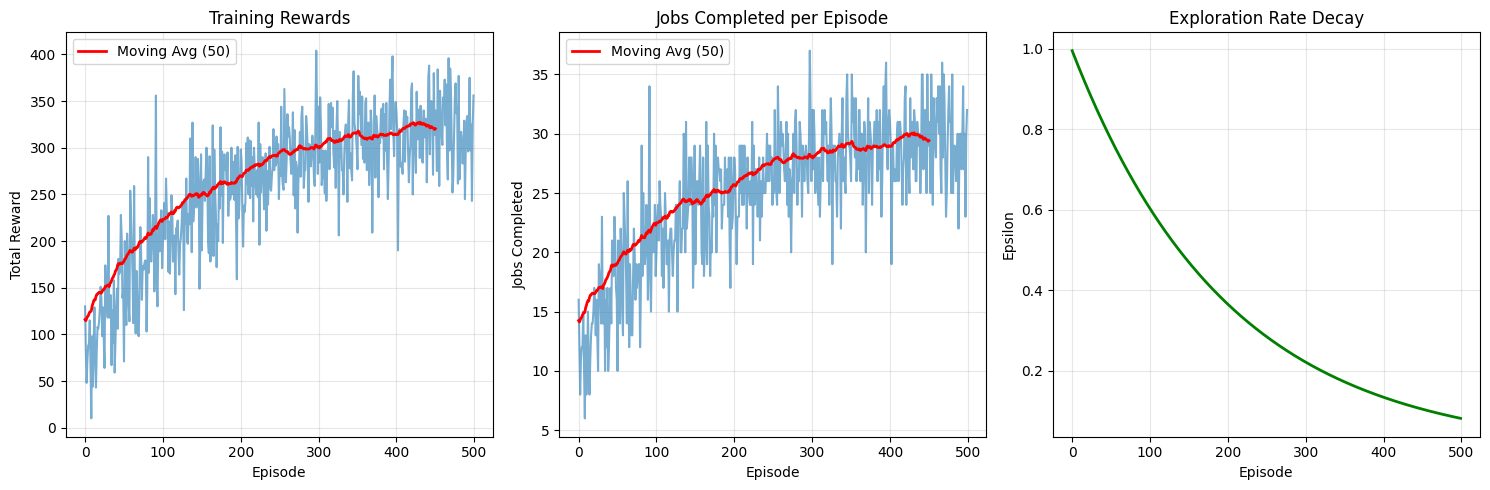


COMPARISON WITH Q-LEARNING BASELINE
Q-Learning (from checkpoint): ~20-21 jobs/episode
Masked DQN (last 50 episodes): 29.42 jobs/episode


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
config_warehouse = {
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_min': 0.05,
    'epsilon_decay': 0.995,
    'learning_rate': 0.0005,
    'batch_size': 64,
    'buffer_size': 10000,
    'target_update': 10,
}

# Create environment and agent
env_warehouse = WarehouseTaskAllocationEnv()
agent_dqn = MaskedDQNAgent(
    state_dim=7,      # Your observation space
    action_dim=12,    # 3 × 2 × 2 joint actions
    config=config_warehouse
)

# Initialize replay buffer
agent_dqn.memory = MaskedReplayBuffer(config_warehouse['buffer_size'])

print("\n" + "=" * 60)
print("TRAINING MASKED DQN ON WAREHOUSE ENVIRONMENT")
print("=" * 60)
print(f"State dim: 7")
print(f"Action dim: 12 (joint actions)")
print(f"Network: {agent_dqn.q_network}")
print("=" * 60)

# Train
metrics_dqn = train_masked_dqn(env_warehouse, agent_dqn, num_episodes=500)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(metrics_dqn['episode_rewards'], alpha=0.6)
plt.plot(np.convolve(metrics_dqn['episode_rewards'], np.ones(50)/50, mode='valid'),
         'r-', linewidth=2, label='Moving Avg (50)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(metrics_dqn['jobs_completed'], alpha=0.6)
plt.plot(np.convolve(metrics_dqn['jobs_completed'], np.ones(50)/50, mode='valid'),
         'r-', linewidth=2, label='Moving Avg (50)')
plt.xlabel('Episode')
plt.ylabel('Jobs Completed')
plt.title('Jobs Completed per Episode')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(metrics_dqn['epsilon_history'], 'g-', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Exploration Rate Decay')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare with your Q-learning baseline
print("\n" + "=" * 60)
print("COMPARISON WITH Q-LEARNING BASELINE")
print("=" * 60)
print(f"Q-Learning (from checkpoint): ~20-21 jobs/episode")
print(f"Masked DQN (last 50 episodes): {np.mean(metrics_dqn['jobs_completed'][-50:]):.2f} jobs/episode")
print("=" * 60)

In [ ]:
def evaluate_masked_dqn(env, agent, num_episodes=10):
    """Evaluate trained agent (greedy policy)."""
    eval_rewards = []
    eval_jobs = []

    for ep in range(num_episodes):
        obs, info = env.reset(seed=777 + ep)
        episode_reward = 0

        for step in range(env.episode_length):
            mask = get_action_mask(env)
            action_idx = agent.select_action(obs, mask, training=False)  # Greedy!
            action_dict = joint_action_to_dict(action_idx)

            obs, reward, terminated, truncated, info = env.step(action_dict)
            episode_reward += reward

            if terminated or truncated:
                break

        eval_rewards.append(episode_reward)
        eval_jobs.append(info['total_jobs_completed'])
        print(f"Eval Episode {ep+1}: Reward={episode_reward:.0f}, Jobs={info['total_jobs_completed']}")

    print(f"\nGreedy Evaluation Results:")
    print(f"  Avg Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"  Avg Jobs: {np.mean(eval_jobs):.2f} ± {np.std(eval_jobs):.2f}")

    return eval_rewards, eval_jobs

# Run evaluation
eval_rewards, eval_jobs = evaluate_masked_dqn(env_warehouse, agent_dqn, num_episodes=10)

Eval Episode 1: Reward=344, Jobs=31
Eval Episode 2: Reward=299, Jobs=28
Eval Episode 3: Reward=367, Jobs=33
Eval Episode 4: Reward=363, Jobs=33
Eval Episode 5: Reward=340, Jobs=31
Eval Episode 6: Reward=299, Jobs=27
Eval Episode 7: Reward=294, Jobs=26
Eval Episode 8: Reward=346, Jobs=31
Eval Episode 9: Reward=325, Jobs=31
Eval Episode 10: Reward=324, Jobs=29

Greedy Evaluation Results:
  Avg Reward: 330.10 ± 25.08
  Avg Jobs: 30.00 ± 2.28


# Proximal Policy Optimization

## Masked PPO Implementation

### Overview
Proximal Policy Optimization with action masking. Uses actor-critic architecture
with clipped surrogate objective for stable policy updates.

### Architecture

| Component | Structure | Output |
|-----------|-----------|--------|
| **Actor** | 7 → 64 → 64 → 12 | Action probabilities |
| **Critic** | 7 → 64 → 64 → 1 | State value V(s) |

### Action Masking in PPO
```python
# Set invalid logits to -infinity before softmax
masked_logits[mask == 0] = -float('inf')
probs = softmax(masked_logits)  # Invalid actions get 0 probability
action = sample(probs)          # Only valid actions sampled
```

### PPO Clipped Objective
```
L = min(r(θ)·A, clip(r(θ), 1-ε, 1+ε)·A)

r(θ) = π_new(a|s) / π_old(a|s)  # Probability ratio
A = advantage                    # How much better than expected
ε = 0.2                          # Clip range
```

### Hyperparameters

| Parameter | Value |
|-----------|-------|
| Learning Rate | 3e-4 |
| Discount (γ) | 0.99 |
| GAE Lambda (λ) | 0.95 |
| Clip Range (ε) | 0.2 |
| Update Epochs | 4 |
| Entropy Coefficient | 0.01 |
| Value Loss Coefficient | 0.5 |

### Results

| Metric | Value |
|--------|-------|
| Jobs/Episode | ~30 |
| vs Q-Learning | +45% |
| vs Baseline | +100% |

### Why PPO over DQN?
1. **More stable training** — clipping prevents catastrophic updates
2. **Natural for continuous actions** — learns distributions
3. **Better for multi-agent** — actor-critic extends naturally to CTDE
4. **Entropy bonus** — automatic exploration without ε-greedy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# ============================================================
# NETWORKS
# ============================================================

class ActorNetwork(nn.Module):
    """Actor (Policy) Network - outputs action probabilities"""
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        logits = self.fc_out(x)
        return logits

class CriticNetwork(nn.Module):
    """Critic (Value) Network - outputs state value"""
    def __init__(self, state_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        value = self.fc_out(x)
        return value

# ============================================================
# ACTION MASKING
# ============================================================


def apply_action_mask_ppo(logits, mask):
    """
    Apply action mask and return valid probabilities
    SAFE VERSION - handles edge cases
    """
    # Clone to avoid modifying original
    masked_logits = logits.clone()

    # Set invalid actions to -inf
    masked_logits[mask == 0] = -float('inf')

    # Check if ALL actions are masked (shouldn't happen, but safety check)
    if torch.all(mask == 0):
        # Emergency fallback: uniform distribution over all actions
        print("WARNING: All actions masked! Using uniform distribution.")
        return torch.ones_like(logits) / logits.shape[-1]

    # Apply softmax
    probs = F.softmax(masked_logits, dim=-1)

    # Safety check for NaN
    if torch.isnan(probs).any():
        print(f"WARNING: NaN detected in probs! logits={logits}, mask={mask}")
        # Fallback to masked uniform distribution
        valid_mask = mask.clone()
        probs = valid_mask / valid_mask.sum(dim=-1, keepdim=True)

    return probs
# ============================================================
# PPO AGENT
# ============================================================

class MaskedPPOAgent:
    """PPO Agent with Action Masking"""
    def __init__(self, state_dim, action_dim, config):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Hyperparameters
        self.gamma = config.get('gamma', 0.99)
        self.learning_rate = config.get('learning_rate', 3e-4)
        self.clip_epsilon = config.get('clip_epsilon', 0.2)
        self.value_coef = config.get('value_coef', 0.5)
        self.entropy_coef = config.get('entropy_coef', 0.01)
        self.max_grad_norm = config.get('max_grad_norm', 0.5)
        self.ppo_epochs = config.get('ppo_epochs', 4)

        # Networks
        self.actor = ActorNetwork(state_dim, action_dim).to(self.device)
        self.critic = CriticNetwork(state_dim).to(self.device)

        # Optimizer
        self.optimizer = optim.Adam(
            list(self.actor.parameters()) + list(self.critic.parameters()),
            lr=self.learning_rate
        )

        # Rollout buffer
        self.reset_rollout_buffer()

    def reset_rollout_buffer(self):
        """Clear rollout storage"""
        self.states = []
        self.actions = []
        self.rewards = []
        self.masks = []
        self.log_probs = []
        self.values = []

    def select_action(self, state, mask, training=True):
        """Select action using current policy"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            mask_tensor = torch.FloatTensor(mask).unsqueeze(0).to(self.device)

            # Get logits and value
            logits = self.actor(state_tensor)
            value = self.critic(state_tensor)

            # Apply mask
            probs = apply_action_mask_ppo(logits, mask_tensor)

            # Sample action
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            return action.item(), log_prob.item(), value.item()

    def store_transition(self, state, action, reward, mask, log_prob, value):
        """Store transition in rollout buffer"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.masks.append(mask)
        self.log_probs.append(log_prob)
        self.values.append(value)

    def compute_returns(self):
        """Compute discounted returns"""
        returns = []
        R = 0
        for reward in reversed(self.rewards):
            R = reward + self.gamma * R
            returns.insert(0, R)
        return torch.FloatTensor(returns).to(self.device)

    def train_step(self):
        """PPO training step"""
        if len(self.states) == 0:
            return None

        # Convert to tensors
        states = torch.FloatTensor(np.array(self.states)).to(self.device)
        actions = torch.LongTensor(self.actions).to(self.device)
        old_log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        masks = torch.FloatTensor(np.array(self.masks)).to(self.device)

        # Compute returns and advantages
        returns = self.compute_returns()
        old_values = torch.FloatTensor(self.values).to(self.device)
        advantages = returns - old_values

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update epochs
        for _ in range(self.ppo_epochs):
            # Forward pass
            logits = self.actor(states)
            probs = apply_action_mask_ppo(logits, masks)
            values = self.critic(states).squeeze()

            # Distribution
            dist = torch.distributions.Categorical(probs)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            # Ratio and clipping
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages

            # Losses
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(values, returns)

            # Total loss
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(self.actor.parameters()) + list(self.critic.parameters()),
                self.max_grad_norm
            )
            self.optimizer.step()

        # Clear buffer
        self.reset_rollout_buffer()

        return loss.item()

In [ ]:
# ============================================================
# ACTION MASKING FOR WAREHOUSE ENVIRONMENT
# ============================================================

def get_action_mask(env):
    """
    Compute action mask for warehouse environment.
    Returns binary vector: 1 = feasible, 0 = infeasible

    Joint action space (12 actions):
    - Dispatcher: 3 choices (station 0, station 1, reject)
    - Acceptor 0: 2 choices (reject, accept)
    - Acceptor 1: 2 choices (reject, accept)
    Total: 3 × 2 × 2 = 12 combinations
    """
    mask = np.ones(12, dtype=np.float32)  # Start with all valid

    # If no pending job, only "reject" actions are valid
    if env.pending_job is None:
        # When no job pending, only dispatcher action 2 (reject) makes sense
        # This means only actions where dispatcher = 2 are valid
        for i in range(12):
            d = i // 4  # dispatcher action (0, 1, 2)
            if d < 2:  # If dispatcher tries to route (not reject)
                mask[i] = 0
        return mask

    # Check each of the 12 joint actions
    for action_idx in range(12):
        # Decode joint action
        d = action_idx // 4           # Dispatcher: 0, 1, 2
        remainder = action_idx % 4
        a0 = remainder // 2           # Acceptor 0: 0 (reject), 1 (accept)
        a1 = remainder % 2            # Acceptor 1: 0 (reject), 1 (accept)

        # If dispatcher chooses reject (d=2), always valid
        if d == 2:
            continue

        # If dispatcher routes to station d
        target_station = d

        # Check if acceptor accepts
        if (d == 0 and a0 == 1) or (d == 1 and a1 == 1):
            # Check queue capacity
            if len(env.station_queues[target_station]) >= env.max_queue_length:
                mask[action_idx] = 0  # Mask out - queue full

    return mask


def joint_action_to_dict(action_idx):
    """
    Convert joint action index (0-11) to environment action dict.

    Mapping:
    - d = action_idx // 4  (dispatcher: 0, 1, 2)
    - a0 = (action_idx % 4) // 2  (acceptor_0: 0, 1)
    - a1 = action_idx % 2  (acceptor_1: 0, 1)
    """
    d = action_idx // 4
    remainder = action_idx % 4
    a0 = remainder // 2
    a1 = remainder % 2

    return {
        'dispatcher': d,
        'acceptor_0': a0,
        'acceptor_1': a1
    }

In [ ]:
def train_masked_ppo(env, agent, num_episodes=500, train_freq=1):
    """
    Train Masked PPO on warehouse environment

    Args:
        train_freq: Train every N episodes (1 = train after each episode)
    """
    episode_rewards = []
    jobs_completed = []
    losses = []

    print("Starting Masked PPO Training...")
    print(f"Device: {agent.device}")
    print("=" * 60)

    for episode in range(num_episodes):
        obs, info = env.reset(seed=42 + episode)
        episode_reward = 0

        for step in range(env.episode_length):
            # Get action mask
            mask = get_action_mask(env)

            # Select action
            action_idx, log_prob, value = agent.select_action(obs, mask, training=True)

            # Convert to environment format
            action_dict = joint_action_to_dict(action_idx)

            # Take step
            next_obs, reward, terminated, truncated, info = env.step(action_dict)
            done = terminated or truncated

            # Store transition
            agent.store_transition(obs, action_idx, reward, mask, log_prob, value)

            obs = next_obs
            episode_reward += reward

            if done:
                break

        # Train after collecting episode
        if (episode + 1) % train_freq == 0:
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)

        # Track metrics
        episode_rewards.append(episode_reward)
        jobs_completed.append(info['total_jobs_completed'])

        # Print progress
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{num_episodes}")
            print(f"  Avg Reward: {np.mean(episode_rewards[-50:]):.2f}")
            print(f"  Avg Jobs: {np.mean(jobs_completed[-50:]):.2f}")
            if losses:
                print(f"  Avg Loss: {np.mean(losses[-50:]):.4f}")
            print("-" * 60)

    return {
        'episode_rewards': episode_rewards,
        'jobs_completed': jobs_completed,
        'losses': losses
    }

PPO Training :

In [ ]:
# Configuration
config_ppo = {
    'gamma': 0.99,
    'learning_rate': 3e-4,
    'clip_epsilon': 0.2,
    'value_coef': 0.5,
    'entropy_coef': 0.01,
    'max_grad_norm': 0.5,
    'ppo_epochs': 4
}

# Create environment and agent
env_ppo = WarehouseTaskAllocationEnv()
agent_ppo = MaskedPPOAgent(
    state_dim=7,
    action_dim=12,
    config=config_ppo
)

print("\n" + "=" * 60)
print("TRAINING MASKED PPO ON WAREHOUSE ENVIRONMENT")
print("=" * 60)
print(f"State dim: 7")
print(f"Action dim: 12")
print("=" * 60)

# Train
metrics_ppo = train_masked_ppo(env_ppo, agent_ppo, num_episodes=500, train_freq=1)

✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions

TRAINING MASKED PPO ON WAREHOUSE ENVIRONMENT
State dim: 7
Action dim: 12
Starting Masked PPO Training...
Device: cuda
Episode 50/500
  Avg Reward: 148.14
  Avg Jobs: 16.68
  Avg Loss: 2836.5427
------------------------------------------------------------
Episode 100/500
  Avg Reward: 247.14
  Avg Jobs: 24.14
  Avg Loss: 6504.4566
------------------------------------------------------------
Episode 150/500
  Avg Reward: 309.12
  Avg Jobs: 28.84
  Avg Loss: 9452.2295
------------------------------------------------------------
Episode 200/500
  Avg Reward: 293.74
  Avg Jobs: 27.56
  Avg Loss: 7574.5414
------------------------------------------------------------
Episode 250/500
  Avg Reward: 344.08
  Avg Jobs: 31.46
  Avg Loss: 9986.6317
------------------------------------------------------------
Episode 300/500
  Avg Reward: 341.24
  Avg

In [ ]:
def evaluate_masked_ppo(env, agent, num_episodes=10):
    """Evaluate trained PPO agent (deterministic policy)"""
    eval_rewards = []
    eval_jobs = []

    print("\n" + "=" * 60)
    print("EVALUATING MASKED PPO (GREEDY POLICY)")
    print("=" * 60)

    for ep in range(num_episodes):
        obs, info = env.reset(seed=777 + ep)
        episode_reward = 0

        for step in range(env.episode_length):
            mask = get_action_mask(env)

            # GREEDY: Pick action with highest probability
            with torch.no_grad():
                state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(agent.device)
                mask_tensor = torch.FloatTensor(mask).unsqueeze(0).to(agent.device)

                logits = agent.actor(state_tensor)
                probs = apply_action_mask_ppo(logits, mask_tensor)

                action_idx = torch.argmax(probs, dim=-1).item()  # Greedy!

            action_dict = joint_action_to_dict(action_idx)
            obs, reward, terminated, truncated, info = env.step(action_dict)
            episode_reward += reward

            if terminated or truncated:
                break

        eval_rewards.append(episode_reward)
        eval_jobs.append(info['total_jobs_completed'])
        print(f"Eval Episode {ep+1}: Reward={episode_reward:.0f}, Jobs={info['total_jobs_completed']}")

    print("\n" + "=" * 60)
    print(f"GREEDY EVALUATION RESULTS:")
    print(f"  Avg Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"  Avg Jobs: {np.mean(eval_jobs):.2f} ± {np.std(eval_jobs):.2f}")
    print("=" * 60)

    return eval_rewards, eval_jobs

# Run evaluation
eval_rewards, eval_jobs = evaluate_masked_ppo(env_ppo, agent_ppo, num_episodes=10)


EVALUATING MASKED PPO (GREEDY POLICY)
Eval Episode 1: Reward=354, Jobs=32
Eval Episode 2: Reward=368, Jobs=33
Eval Episode 3: Reward=397, Jobs=36
Eval Episode 4: Reward=363, Jobs=33
Eval Episode 5: Reward=420, Jobs=38
Eval Episode 6: Reward=299, Jobs=27
Eval Episode 7: Reward=324, Jobs=29
Eval Episode 8: Reward=386, Jobs=35
Eval Episode 9: Reward=421, Jobs=38
Eval Episode 10: Reward=334, Jobs=30

GREEDY EVALUATION RESULTS:
  Avg Reward: 366.60 ± 38.38
  Avg Jobs: 33.10 ± 3.53


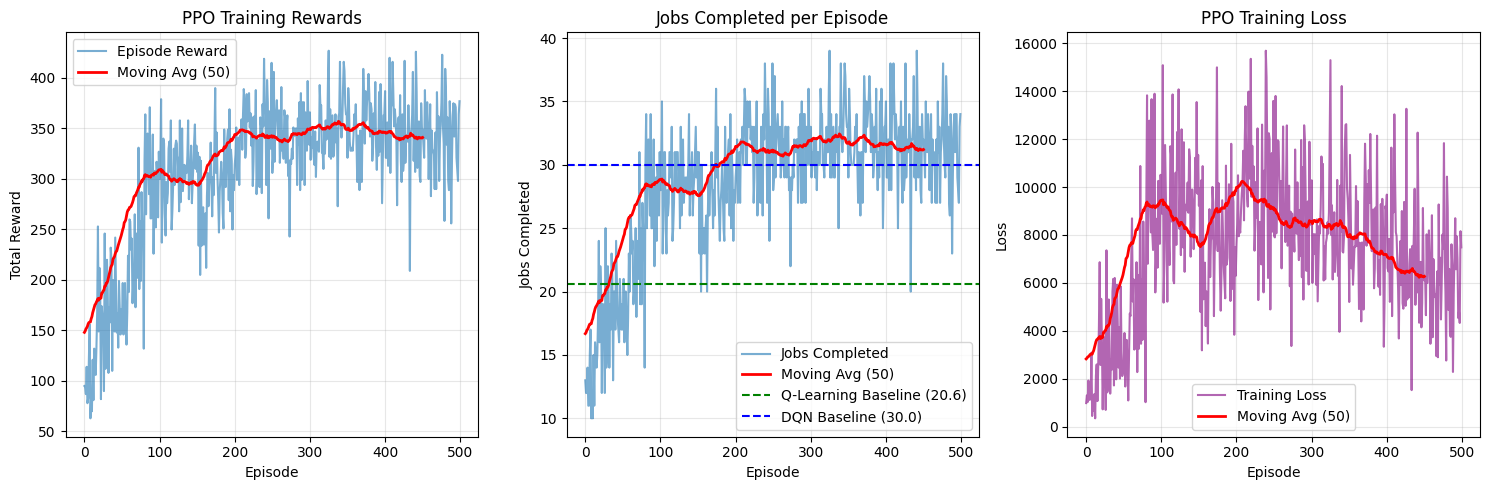


ALGORITHM COMPARISON
Tabular Q-Learning: ~20-21 jobs/episode (checkpoint)
Masked DQN:         ~30.00 jobs/episode (Day 1)
Masked PPO:         ~31.20 jobs/episode (Day 2)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Rewards
plt.subplot(1, 3, 1)
plt.plot(metrics_ppo['episode_rewards'], alpha=0.6, label='Episode Reward')
plt.plot(np.convolve(metrics_ppo['episode_rewards'], np.ones(50)/50, mode='valid'),
         'r-', linewidth=2, label='Moving Avg (50)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Training Rewards')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Jobs Completed
plt.subplot(1, 3, 2)
plt.plot(metrics_ppo['jobs_completed'], alpha=0.6, label='Jobs Completed')
plt.plot(np.convolve(metrics_ppo['jobs_completed'], np.ones(50)/50, mode='valid'),
         'r-', linewidth=2, label='Moving Avg (50)')
plt.axhline(y=20.6, color='g', linestyle='--', label='Q-Learning Baseline (20.6)')
plt.axhline(y=30, color='b', linestyle='--', label='DQN Baseline (30.0)')
plt.xlabel('Episode')
plt.ylabel('Jobs Completed')
plt.title('Jobs Completed per Episode')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Loss
plt.subplot(1, 3, 3)
plt.plot(metrics_ppo['losses'], 'purple', alpha=0.6, label='Training Loss')
plt.plot(np.convolve(metrics_ppo['losses'], np.ones(50)/50, mode='valid'),
         'r-', linewidth=2, label='Moving Avg (50)')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('PPO Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "=" * 60)
print("ALGORITHM COMPARISON")
print("=" * 60)
print(f"Tabular Q-Learning: ~20-21 jobs/episode (checkpoint)")
print(f"Masked DQN:         ~30.00 jobs/episode (Day 1)")
print(f"Masked PPO:         ~{np.mean(metrics_ppo['jobs_completed'][-50:]):.2f} jobs/episode (Day 2)")
print("=" * 60)

In [ ]:
import torch
import pickle

# ============================================================
# SAVE PPO MODEL WEIGHTS
# ============================================================

def save_ppo_agent(agent, filepath='ppo_warehouse_agent.pth'):
    """
    Save PPO agent's networks and configuration
    """
    checkpoint = {
        'actor_state_dict': agent.actor.state_dict(),
        'critic_state_dict': agent.critic.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'config': {
            'state_dim': agent.state_dim,
            'action_dim': agent.action_dim,
            'gamma': agent.gamma,
            'learning_rate': agent.learning_rate,
            'clip_epsilon': agent.clip_epsilon,
            'value_coef': agent.value_coef,
            'entropy_coef': agent.entropy_coef,
        }
    }

    torch.save(checkpoint, filepath)
    print(f"✓ PPO agent saved to: {filepath}")
    return filepath

# Save your trained agent
save_ppo_agent(agent_ppo, 'ppo_warehouse_best.pth')

✓ PPO agent saved to: ppo_warehouse_best.pth


'ppo_warehouse_best.pth'

In [ ]:
def save_training_metrics(metrics, filepath='ppo_training_metrics.pkl'):
    """
    Save training history (rewards, jobs completed, losses)
    """
    with open(filepath, 'wb') as f:
        pickle.dump(metrics, f)
    print(f"✓ Training metrics saved to: {filepath}")

# Save your metrics
save_training_metrics(metrics_ppo, 'ppo_training_metrics.pkl')

✓ Training metrics saved to: ppo_training_metrics.pkl


In [ ]:
# If you're on Google Colab, download the files
from google.colab import files

# Download PPO weights
files.download('ppo_warehouse_best.pth')

# Download training metrics
files.download('ppo_training_metrics.pkl')

print("✓ Files ready for download!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Files ready for download!


# Multi Agent PPO with CTDE (Centralized training Decentralized execution)

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================
# ENVIRONMENT (same as before)
# ============================================================

class WarehouseTaskAllocationEnv(gym.Env):
    """
    Multi-Agent Warehouse Environment
    Architecture: 1 Dispatcher + 2 Acceptors (one per station)
    """

    def __init__(self):
        super().__init__()

        # === BASIC PARAMETERS ===
        self.num_stations = 2
        self.max_queue_length = 10
        self.max_processing_time = 5
        self.station_capacity = 2
        self.arrival_rate = 0.7
        self.episode_length = 50

        # === TRACKING VARIABLES ===
        self.current_step = None
        self.station_queues = None
        self.station_processing = None
        self.pending_job = None

        # === METRICS ===
        self.total_jobs_arrived = 0
        self.total_jobs_completed = 0
        self.total_jobs_rejected = 0
        self.wait_times = []

        print("✓ Environment initialized!")
        print(f"  Architecture: 1 Dispatcher + {self.num_stations} Acceptors")

        # === DEFINE SPACES ===
        obs_dim = self.num_stations * 3 + 1
        self.observation_space = spaces.Box(
            low=0,
            high=max(self.max_queue_length, self.max_processing_time, self.station_capacity),
            shape=(obs_dim,),
            dtype=np.float32
        )

        self.dispatcher_action_space = spaces.Discrete(self.num_stations + 1)
        self.acceptor_action_space = spaces.Discrete(2)

        print(f"   Observation space: {self.observation_space.shape}")
        print(f"   Dispatcher: {self.dispatcher_action_space.n} actions")
        print(f"   Each Acceptor: {self.acceptor_action_space.n} actions")

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)

        self.station_queues = [deque() for _ in range(self.num_stations)]
        self.station_processing = [[] for _ in range(self.num_stations)]

        self.current_step = 0
        self.pending_job = None

        self.total_jobs_arrived = 0
        self.total_jobs_completed = 0
        self.total_jobs_rejected = 0
        self.wait_times = []

        if np.random.random() < self.arrival_rate:
            self._generate_job()

        observation = self._get_observation()
        info = self._get_info()

        return observation, info

    def step(self, actions):
        dispatcher_action = actions['dispatcher']
        acceptor_0_action = actions['acceptor_0']
        acceptor_1_action = actions['acceptor_1']

        reward = 0

        # STEP 1: Route pending job
        if self.pending_job is not None:
            if dispatcher_action >= self.num_stations:
                self.total_jobs_rejected += 1
                self.pending_job = None
                reward -= 2
            else:
                target_station = dispatcher_action

                if target_station == 0:
                    acceptor_decision = acceptor_0_action
                else:
                    acceptor_decision = acceptor_1_action

                if acceptor_decision == 1:
                    if len(self.station_queues[target_station]) < self.max_queue_length:
                        self.station_queues[target_station].append(self.pending_job)
                        self.pending_job = None
                        reward += 1

                        # === LOAD BALANCING: Bonus for routing to shorter queue ===
                        other_station = 1 - target_station
                        if len(self.station_queues[target_station]) <= len(self.station_queues[other_station]):
                            reward += 0.5  # Bonus for good routing decision

                    else:
                        self.total_jobs_rejected += 1
                        self.pending_job = None
                        reward -= 5
                else:
                    self.total_jobs_rejected += 1
                    self.pending_job = None
                    reward -= 2

        # STEP 2: Process jobs
        for station_idx in range(self.num_stations):
            while (len(self.station_processing[station_idx]) < self.station_capacity and
                  len(self.station_queues[station_idx]) > 0):
                job = self.station_queues[station_idx].popleft()
                job['remaining_time'] = job['processing_time']
                job['start_processing_time'] = self.current_step
                self.station_processing[station_idx].append(job)

            completed_jobs = []
            for job in self.station_processing[station_idx]:
                job['remaining_time'] -= 1

                if job['remaining_time'] <= 0:
                    completed_jobs.append(job)
                    wait_time = job['start_processing_time'] - job['arrival_time']
                    self.wait_times.append(wait_time)
                    self.total_jobs_completed += 1
                    reward += 10

            for job in completed_jobs:
                self.station_processing[station_idx].remove(job)

        # STEP 3: Penalize congestion
        for station_idx in range(self.num_stations):
            queue_len = len(self.station_queues[station_idx])
            if queue_len > 0.7 * self.max_queue_length:
                penalty = queue_len * 0.8
                reward -= penalty

        # === STEP 3.5: Penalize queue imbalance ===
        q0, q1 = len(self.station_queues[0]), len(self.station_queues[1])
        queue_diff = abs(q0 - q1)
        if queue_diff > 2:
            reward -= 0.3 * queue_diff

        # STEP 4: Generate new job
        if np.random.random() < self.arrival_rate:
            self._generate_job()

        # STEP 5: Increment time
        self.current_step += 1

        # STEP 6: Check termination
        terminated = False
        truncated = self.current_step >= self.episode_length

        observation = self._get_observation()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def _generate_job(self):
        job = {
            'id': self.total_jobs_arrived,
            'processing_time': np.random.randint(1, self.max_processing_time + 1),
            'remaining_time': None,
            'arrival_time': self.current_step,
            'start_processing_time': None,
        }

        self.pending_job = job
        self.total_jobs_arrived += 1

    def _get_observation(self):
        obs = []

        for i in range(self.num_stations):
            queue_len = len(self.station_queues[i])
            num_processing = len(self.station_processing[i])

            if self.station_processing[i]:
                avg_remaining = np.mean([job['remaining_time']
                                        for job in self.station_processing[i]])
            else:
                avg_remaining = 0

            obs.extend([queue_len, num_processing, avg_remaining])

        pending_flag = 1 if self.pending_job is not None else 0
        obs.append(pending_flag)

        return np.array(obs, dtype=np.float32)

    def _get_info(self):
        return {
            'current_step': self.current_step,
            'total_jobs_arrived': self.total_jobs_arrived,
            'total_jobs_completed': self.total_jobs_completed,
            'total_jobs_rejected': self.total_jobs_rejected,
            'queue_lengths': [len(q) for q in self.station_queues],
            'avg_wait_time': np.mean(self.wait_times) if self.wait_times else 0,
        }


# ============================================================
# NETWORKS
# ============================================================

class ActorNetwork(nn.Module):
    """Actor (Policy) Network - outputs action probabilities"""
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, action_dim)

        # Initialize weights with smaller values for stability
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0)
        # Output layer with smaller initialization
        nn.init.orthogonal_(self.fc_out.weight, gain=0.01)
        nn.init.constant_(self.fc_out.bias, 0)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        logits = self.fc_out(x)
        return logits


class CriticNetwork(nn.Module):
    """Critic (Value) Network - outputs state value"""
    def __init__(self, state_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

        # Initialize weights
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.orthogonal_(layer.weight, gain=np.sqrt(2))
            nn.init.constant_(layer.bias, 0)
        nn.init.orthogonal_(self.fc_out.weight, gain=1.0)
        nn.init.constant_(self.fc_out.bias, 0)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        value = self.fc_out(x)
        return value


# ============================================================
# ACTION MASKING
# ============================================================

def apply_action_mask_safe(logits, mask, log_space=False):
    """
    Apply action mask safely without NaN propagation.

    Key fixes:
    1. Use large negative value instead of -inf to avoid NaN in softmax
    2. Ensure at least one action is always valid
    3. Maintain gradient flow
    """
    # Use large negative number instead of -inf
    MASK_VALUE = -1e8

    # Ensure mask is float
    mask = mask.float()

    # Ensure at least one action is valid per batch element
    # If all masked, unmask the first action as fallback
    batch_has_valid = mask.sum(dim=-1, keepdim=True) > 0
    if not batch_has_valid.all():
        # Create fallback mask with first action valid
        fallback_mask = torch.zeros_like(mask)
        fallback_mask[..., -1] = 1  # Last action (reject) is always safe
        mask = torch.where(batch_has_valid, mask, fallback_mask)

    # Apply mask
    masked_logits = logits + (1 - mask) * MASK_VALUE

    if log_space:
        # Return log probabilities
        log_probs = F.log_softmax(masked_logits, dim=-1)
        return log_probs
    else:
        # Return probabilities
        probs = F.softmax(masked_logits, dim=-1)
        return probs


def get_action_mask(env):
    """
    Compute action mask for warehouse environment.
    Returns binary vector: 1 = feasible, 0 = infeasible
    """
    mask = np.ones(12, dtype=np.float32)

    if env.pending_job is None:
        for i in range(12):
            d = i // 4
            if d < 2:
                mask[i] = 0
        return mask

    for action_idx in range(12):
        d = action_idx // 4
        remainder = action_idx % 4
        a0 = remainder // 2
        a1 = remainder % 2

        if d == 2:
            continue

        target_station = d

        if (d == 0 and a0 == 1) or (d == 1 and a1 == 1):
            if len(env.station_queues[target_station]) >= env.max_queue_length:
                mask[action_idx] = 0

    return mask


def joint_action_to_dict(action_idx):
    """Convert joint action index (0-11) to environment action dict."""
    d = action_idx // 4
    remainder = action_idx % 4
    a0 = remainder // 2
    a1 = remainder % 2

    return {
        'dispatcher': d,
        'acceptor_0': a0,
        'acceptor_1': a1
    }


# ============================================================
# MULTI-AGENT PPO SYSTEM
# ============================================================

class FixedMultiAgentPPO:
    """
    Fixed Multi-Agent PPO with CTDE for Warehouse

    Key fixes:
    1. Minimum batch size for training
    2. Gradient clipping
    3. Lower learning rate
    4. Proper tensor shape handling
    5. Log probability clamping
    """

    def __init__(self, state_dim, config):
        self.state_dim = state_dim
        self.num_stations = 2
        self.device = device

        # Hyperparameters (more conservative)
        self.gamma = config.get('gamma', 0.99)
        self.learning_rate = config.get('learning_rate', 1e-4)  # Lower LR
        self.clip_epsilon = config.get('clip_epsilon', 0.2)
        self.value_coef = config.get('value_coef', 0.5)
        self.entropy_coef = config.get('entropy_coef', 0.01)
        self.ppo_epochs = config.get('ppo_epochs', 4)
        self.min_batch_size = config.get('min_batch_size', 10)  # NEW: minimum batch
        self.max_grad_norm = config.get('max_grad_norm', 0.5)

        # Create Actor networks (one per agent)
        self.dispatcher_actor = ActorNetwork(state_dim, 3).to(self.device)
        self.acceptor_actors = nn.ModuleList([
            ActorNetwork(state_dim, 2).to(self.device)
            for _ in range(self.num_stations)
        ])

        # Create SHARED Critic network
        self.shared_critic = CriticNetwork(state_dim).to(self.device)

        # Single optimizer for ALL networks (with weight decay for stability)
        all_params = (
            list(self.dispatcher_actor.parameters()) +
            list(self.acceptor_actors.parameters()) +
            list(self.shared_critic.parameters())
        )
        self.optimizer = optim.Adam(all_params, lr=self.learning_rate, eps=1e-5)

        # Rollout buffers
        self.reset_rollout_buffers()

        print("✓ Fixed Multi-Agent PPO initialized!")
        print(f"  - 1 Dispatcher (3 actions)")
        print(f"  - {self.num_stations} Acceptors (2 actions each)")
        print(f"  - 1 Shared Critic")
        print(f"  - Learning rate: {self.learning_rate}")
        print(f"  - Min batch size: {self.min_batch_size}")

    def reset_rollout_buffers(self):
        """Reset rollout storage for all agents"""
        self.dispatcher_buffer = {
            'states': [],
            'actions': [],
            'log_probs': [],
            'rewards': [],
            'masks': [],
            'values': []
        }

        self.acceptor_buffers = [
            {
                'states': [],
                'actions': [],
                'log_probs': [],
                'rewards': [],
                'masks': [],
                'values': []
            }
            for _ in range(self.num_stations)
        ]

    def select_actions(self, state, mask, training=True):
        """Sequential action selection with proper tensor handling"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

            # Get shared value estimate
            value = self.shared_critic(state_tensor).item()

            # STEP 1: Dispatcher decides
            dispatcher_mask = self._get_dispatcher_mask(mask)
            dispatcher_mask_tensor = torch.FloatTensor(dispatcher_mask).unsqueeze(0).to(self.device)

            dispatcher_logits = self.dispatcher_actor(state_tensor)
            dispatcher_probs = apply_action_mask_safe(dispatcher_logits, dispatcher_mask_tensor)

            dispatcher_dist = torch.distributions.Categorical(dispatcher_probs)
            dispatcher_action = dispatcher_dist.sample().item()
            dispatcher_log_prob = dispatcher_dist.log_prob(
                torch.tensor(dispatcher_action, device=self.device)
            ).item()

            # Clamp log prob to prevent extreme values
            dispatcher_log_prob = np.clip(dispatcher_log_prob, -20, 0)

            # STEP 2: Acceptor decides
            acceptor_actions = [0, 0]
            acceptor_log_probs = [0.0, 0.0]
            acceptor_values = [value, value]  # Same value estimate for all

            if dispatcher_action < 2:
                target_station = dispatcher_action

                acceptor_mask = self._get_acceptor_mask(mask, target_station)
                acceptor_mask_tensor = torch.FloatTensor(acceptor_mask).unsqueeze(0).to(self.device)

                acceptor_logits = self.acceptor_actors[target_station](state_tensor)
                acceptor_probs = apply_action_mask_safe(acceptor_logits, acceptor_mask_tensor)

                acceptor_dist = torch.distributions.Categorical(acceptor_probs)
                acceptor_action = acceptor_dist.sample().item()
                acceptor_log_prob = acceptor_dist.log_prob(
                    torch.tensor(acceptor_action, device=self.device)
                ).item()

                # Clamp log prob
                acceptor_log_prob = np.clip(acceptor_log_prob, -20, 0)

                acceptor_actions[target_station] = acceptor_action
                acceptor_log_probs[target_station] = acceptor_log_prob

            # STEP 3: Convert to environment format
            final_action_dict = {
                'dispatcher': dispatcher_action,
                'acceptor_0': acceptor_actions[0],
                'acceptor_1': acceptor_actions[1]
            }

            return (
                final_action_dict,
                dispatcher_action,
                acceptor_actions,
                dispatcher_log_prob,
                acceptor_log_probs,
                value
            )

    def _get_dispatcher_mask(self, full_mask):
        """Extract dispatcher mask from full joint action mask"""
        station_0_valid = any(full_mask[i] == 1 for i in [0, 1, 2, 3])
        station_1_valid = any(full_mask[i] == 1 for i in [4, 5, 6, 7])
        reject_valid = 1

        return np.array([station_0_valid, station_1_valid, reject_valid], dtype=np.float32)

    def _get_acceptor_mask(self, full_mask, station_idx):
        """Extract acceptor mask for a specific station"""
        reject_valid = 1

        if station_idx == 0:
            accept_valid = any(full_mask[i] == 1 for i in [1, 3])
        else:
            accept_valid = any(full_mask[i] == 1 for i in [5, 7])

        return np.array([reject_valid, accept_valid], dtype=np.float32)

    def store_transition(self, state, dispatcher_action, acceptor_actions,
                        dispatcher_log_prob, acceptor_log_probs,
                        reward, mask, value):
        """Store transition for all agents that acted"""
        # Dispatcher always acts
        self.dispatcher_buffer['states'].append(state.copy())
        self.dispatcher_buffer['actions'].append(dispatcher_action)
        self.dispatcher_buffer['log_probs'].append(dispatcher_log_prob)
        self.dispatcher_buffer['rewards'].append(reward)
        self.dispatcher_buffer['masks'].append(self._get_dispatcher_mask(mask))
        self.dispatcher_buffer['values'].append(value)

        # Only store for acceptor that was queried
        if dispatcher_action < 2:
            target_station = dispatcher_action

            self.acceptor_buffers[target_station]['states'].append(state.copy())
            self.acceptor_buffers[target_station]['actions'].append(acceptor_actions[target_station])
            self.acceptor_buffers[target_station]['log_probs'].append(acceptor_log_probs[target_station])
            self.acceptor_buffers[target_station]['rewards'].append(reward)
            self.acceptor_buffers[target_station]['masks'].append(
                self._get_acceptor_mask(mask, target_station)
            )
            self.acceptor_buffers[target_station]['values'].append(value)

    def compute_returns_and_advantages(self, rewards, values):
        """Compute discounted returns and GAE advantages"""
        returns = []
        advantages = []

        R = 0
        for i in reversed(range(len(rewards))):
            R = rewards[i] + self.gamma * R
            returns.insert(0, R)

        returns = torch.FloatTensor(returns).to(self.device)
        values = torch.FloatTensor(values).to(self.device)

        advantages = returns - values

        # Normalize advantages only if we have enough samples
        if len(advantages) > 1:
            adv_mean = advantages.mean()
            adv_std = advantages.std()
            if adv_std > 1e-8:  # Only normalize if std is meaningful
                advantages = (advantages - adv_mean) / (adv_std + 1e-8)

        return returns, advantages

    def train_step(self):
        """Multi-agent PPO training step with stability fixes"""
        dispatcher_loss = self._train_agent_safe(
            self.dispatcher_actor,
            self.dispatcher_buffer,
            agent_name="Dispatcher"
        )

        acceptor_losses = []
        for i, acceptor_buffer in enumerate(self.acceptor_buffers):
            if len(acceptor_buffer['states']) >= self.min_batch_size:
                loss = self._train_agent_safe(
                    self.acceptor_actors[i],
                    acceptor_buffer,
                    agent_name=f"Acceptor_{i}"
                )
                acceptor_losses.append(loss)

        # Clear buffers
        self.reset_rollout_buffers()

        # Return average loss (excluding None values)
        all_losses = [l for l in [dispatcher_loss] + acceptor_losses if l is not None]
        return np.mean(all_losses) if all_losses else None

    def _train_agent_safe(self, actor_network, buffer, agent_name="Agent"):
        """Train a single agent's actor network with stability checks"""

        # Check minimum batch size
        if len(buffer['states']) < self.min_batch_size:
            return None

        # Convert to tensors
        states = torch.FloatTensor(np.array(buffer['states'])).to(self.device)
        actions = torch.LongTensor(buffer['actions']).to(self.device)
        old_log_probs = torch.FloatTensor(buffer['log_probs']).to(self.device)
        masks = torch.FloatTensor(np.array(buffer['masks'])).to(self.device)

        # Compute returns and advantages
        returns, advantages = self.compute_returns_and_advantages(
            buffer['rewards'], buffer['values']
        )

        # Check for NaN in inputs
        if torch.isnan(states).any() or torch.isnan(old_log_probs).any():
            print(f"WARNING: NaN detected in {agent_name} inputs, skipping training")
            return None

        epoch_losses = []

        for epoch in range(self.ppo_epochs):
            # Forward pass
            logits = actor_network(states)

            # Check for NaN in logits
            if torch.isnan(logits).any():
                print(f"WARNING: NaN in {agent_name} logits at epoch {epoch}, skipping")
                continue

            probs = apply_action_mask_safe(logits, masks)
            values = self.shared_critic(states).squeeze(-1)

            # Distribution
            dist = torch.distributions.Categorical(probs)
            new_log_probs = dist.log_prob(actions)

            # Clamp log probs to prevent extreme ratios
            new_log_probs = torch.clamp(new_log_probs, -20, 0)
            old_log_probs_clamped = torch.clamp(old_log_probs, -20, 0)

            entropy = dist.entropy().mean()

            # Ratio and clipping
            ratio = torch.exp(new_log_probs - old_log_probs_clamped)

            # Clamp ratio to prevent explosion
            ratio = torch.clamp(ratio, 0.01, 100)

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages

            # Losses
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(values, returns)

            # Total loss
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy

            # Check for NaN loss
            if torch.isnan(loss):
                print(f"WARNING: NaN loss in {agent_name} at epoch {epoch}, skipping")
                continue

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                list(actor_network.parameters()) + list(self.shared_critic.parameters()),
                self.max_grad_norm
            )

            self.optimizer.step()

            epoch_losses.append(loss.item())

        return np.mean(epoch_losses) if epoch_losses else None


def train_fixed_multi_agent_ppo(env, ma_system, num_episodes=500):
    """
    Train Fixed Multi-Agent PPO on warehouse environment
    """
    episode_rewards = []
    jobs_completed = []
    losses = []

    print("\n" + "=" * 60)
    print("TRAINING FIXED MULTI-AGENT PPO (CTDE)")
    print("=" * 60)
    print(f"Device: {ma_system.device}")
    print("=" * 60)

    for episode in range(num_episodes):
        obs, info = env.reset(seed=42 + episode)
        episode_reward = 0

        for step in range(env.episode_length):
            # Get full action mask
            mask = get_action_mask(env)

            # Select actions (sequential)
            (action_dict, disp_action, accept_actions,
             disp_log_prob, accept_log_probs, value) = ma_system.select_actions(obs, mask)

            # Take step
            next_obs, reward, terminated, truncated, info = env.step(action_dict)
            done = terminated or truncated

            # Store transition
            ma_system.store_transition(
                obs, disp_action, accept_actions,
                disp_log_prob, accept_log_probs,
                reward, mask, value
            )

            obs = next_obs
            episode_reward += reward

            if done:
                break

        # Train after each episode
        loss = ma_system.train_step()
        if loss is not None and not np.isnan(loss):
            losses.append(loss)

        # Track metrics
        episode_rewards.append(episode_reward)
        jobs_completed.append(info['total_jobs_completed'])

        # Print progress
        if (episode + 1) % 50 == 0:
            recent_jobs = np.mean(jobs_completed[-50:])
            recent_reward = np.mean(episode_rewards[-50:])
            recent_loss = np.mean(losses[-50:]) if losses else 0

            print(f"Episode {episode + 1}/{num_episodes}")
            print(f"  Avg Reward: {recent_reward:.2f}")
            print(f"  Avg Jobs: {recent_jobs:.2f}")
            print(f"  Avg Loss: {recent_loss:.4f}")
            print("-" * 60)

    return {
        'episode_rewards': episode_rewards,
        'jobs_completed': jobs_completed,
        'losses': losses
    }


def evaluate_fixed_marl(env, ma_system, num_episodes=10):
    """Evaluate trained multi-agent system"""
    eval_rewards = []
    eval_jobs = []

    print("\n" + "=" * 60)
    print("EVALUATING FIXED MULTI-AGENT PPO")
    print("=" * 60)

    for ep in range(num_episodes):
        obs, info = env.reset(seed=777 + ep)
        episode_reward = 0

        for step in range(env.episode_length):
            mask = get_action_mask(env)

            # Greedy action selection
            with torch.no_grad():
                state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(ma_system.device)

                # Dispatcher
                dispatcher_mask = ma_system._get_dispatcher_mask(mask)
                dispatcher_mask_tensor = torch.FloatTensor(dispatcher_mask).unsqueeze(0).to(ma_system.device)
                dispatcher_logits = ma_system.dispatcher_actor(state_tensor)
                dispatcher_probs = apply_action_mask_safe(dispatcher_logits, dispatcher_mask_tensor)
                dispatcher_action = torch.argmax(dispatcher_probs, dim=-1).item()

                # Acceptors
                acceptor_actions = [0, 0]
                if dispatcher_action < 2:
                    target_station = dispatcher_action
                    acceptor_mask = ma_system._get_acceptor_mask(mask, target_station)
                    acceptor_mask_tensor = torch.FloatTensor(acceptor_mask).unsqueeze(0).to(ma_system.device)
                    acceptor_logits = ma_system.acceptor_actors[target_station](state_tensor)
                    acceptor_probs = apply_action_mask_safe(acceptor_logits, acceptor_mask_tensor)
                    acceptor_actions[target_station] = torch.argmax(acceptor_probs, dim=-1).item()

            action_dict = {
                'dispatcher': dispatcher_action,
                'acceptor_0': acceptor_actions[0],
                'acceptor_1': acceptor_actions[1]
            }

            obs, reward, terminated, truncated, info = env.step(action_dict)
            episode_reward += reward

            if terminated or truncated:
                break

        eval_rewards.append(episode_reward)
        eval_jobs.append(info['total_jobs_completed'])
        print(f"Eval Episode {ep+1}: Reward={episode_reward:.0f}, Jobs={info['total_jobs_completed']}")

    print("\n" + "=" * 60)
    print(f"EVALUATION RESULTS:")
    print(f"  Avg Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"  Avg Jobs: {np.mean(eval_jobs):.2f} ± {np.std(eval_jobs):.2f}")
    print("=" * 60)

    return eval_rewards, eval_jobs


# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    # Configuration with more conservative hyperparameters
    config_marl = {
        'gamma': 0.99,
        'learning_rate': 1e-4,  # Lower than before
        'clip_epsilon': 0.2,
        'value_coef': 0.5,
        'entropy_coef': 0.05,
        'ppo_epochs': 4,
        'min_batch_size': 10,  # NEW: ensure enough samples
        'max_grad_norm': 0.5
    }

    # Create environment and multi-agent system
    env_marl = WarehouseTaskAllocationEnv()
    ma_ppo = FixedMultiAgentPPO(state_dim=7, config=config_marl)

    # Train
    metrics_marl = train_fixed_multi_agent_ppo(env_marl, ma_ppo, num_episodes=1500)

    # Evaluate
    eval_rewards, eval_jobs = evaluate_fixed_marl(env_marl, ma_ppo, num_episodes=10)

    # Summary
    print("\n" + "=" * 60)
    print("ALGORITHM COMPARISON")
    print("=" * 60)
    print(f"Tabular Q-Learning: ~20-21 jobs/episode (checkpoint)")
    print(f"Masked DQN:         ~30.00 jobs/episode")
    print(f"Masked PPO:         ~30.00 jobs/episode")
    print(f"Fixed MA-PPO:       ~{np.mean(eval_jobs):.2f} jobs/episode")
    print("=" * 60)

Using device: cuda
✓ Environment initialized!
  Architecture: 1 Dispatcher + 2 Acceptors
   Observation space: (7,)
   Dispatcher: 3 actions
   Each Acceptor: 2 actions
✓ Fixed Multi-Agent PPO initialized!
  - 1 Dispatcher (3 actions)
  - 2 Acceptors (2 actions each)
  - 1 Shared Critic
  - Learning rate: 0.0001
  - Min batch size: 10

TRAINING FIXED MULTI-AGENT PPO (CTDE)
Device: cuda
Episode 50/1500
  Avg Reward: 95.54
  Avg Jobs: 12.68
  Avg Loss: 626.9661
------------------------------------------------------------
Episode 100/1500
  Avg Reward: 131.20
  Avg Jobs: 15.34
  Avg Loss: 798.6319
------------------------------------------------------------
Episode 150/1500
  Avg Reward: 159.48
  Avg Jobs: 17.54
  Avg Loss: 1090.0144
------------------------------------------------------------
Episode 200/1500
  Avg Reward: 211.41
  Avg Jobs: 21.32
  Avg Loss: 1836.2503
------------------------------------------------------------
Episode 250/1500
  Avg Reward: 248.29
  Avg Jobs: 24.16
  A

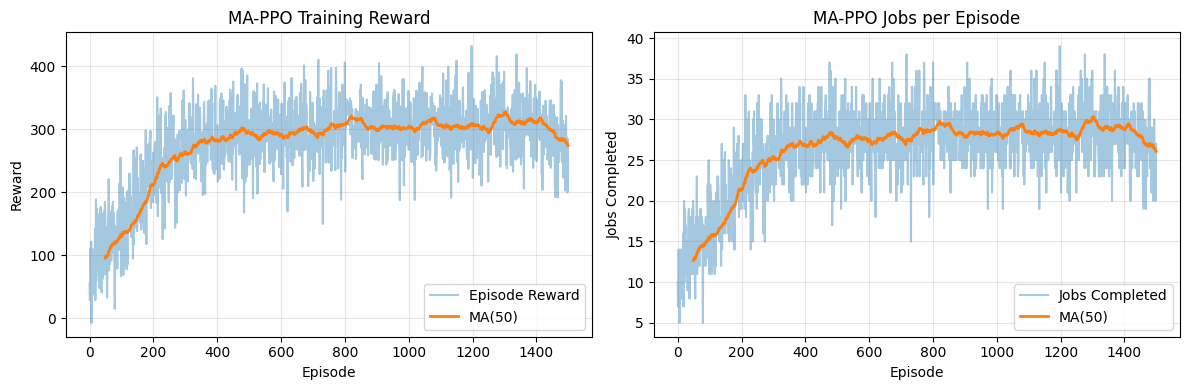

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rewards = metrics_marl['episode_rewards']
jobs = metrics_marl['jobs_completed']

window = 50
def moving_avg(x, w):
    if len(x) < w:
        return np.array(x)
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(12, 4))

# Rewards
plt.subplot(1, 2, 1)
plt.plot(rewards, alpha=0.4, label='Episode Reward')
ma_r = moving_avg(rewards, window)
plt.plot(range(window-1, window-1+len(ma_r)), ma_r, linewidth=2, label=f'MA({window})')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('MA-PPO Training Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Jobs
plt.subplot(1, 2, 2)
plt.plot(jobs, alpha=0.4, label='Jobs Completed')
ma_j = moving_avg(jobs, window)
plt.plot(range(window-1, window-1+len(ma_j)), ma_j, linewidth=2, label=f'MA({window})')
plt.xlabel('Episode')
plt.ylabel('Jobs Completed')
plt.title('MA-PPO Jobs per Episode')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


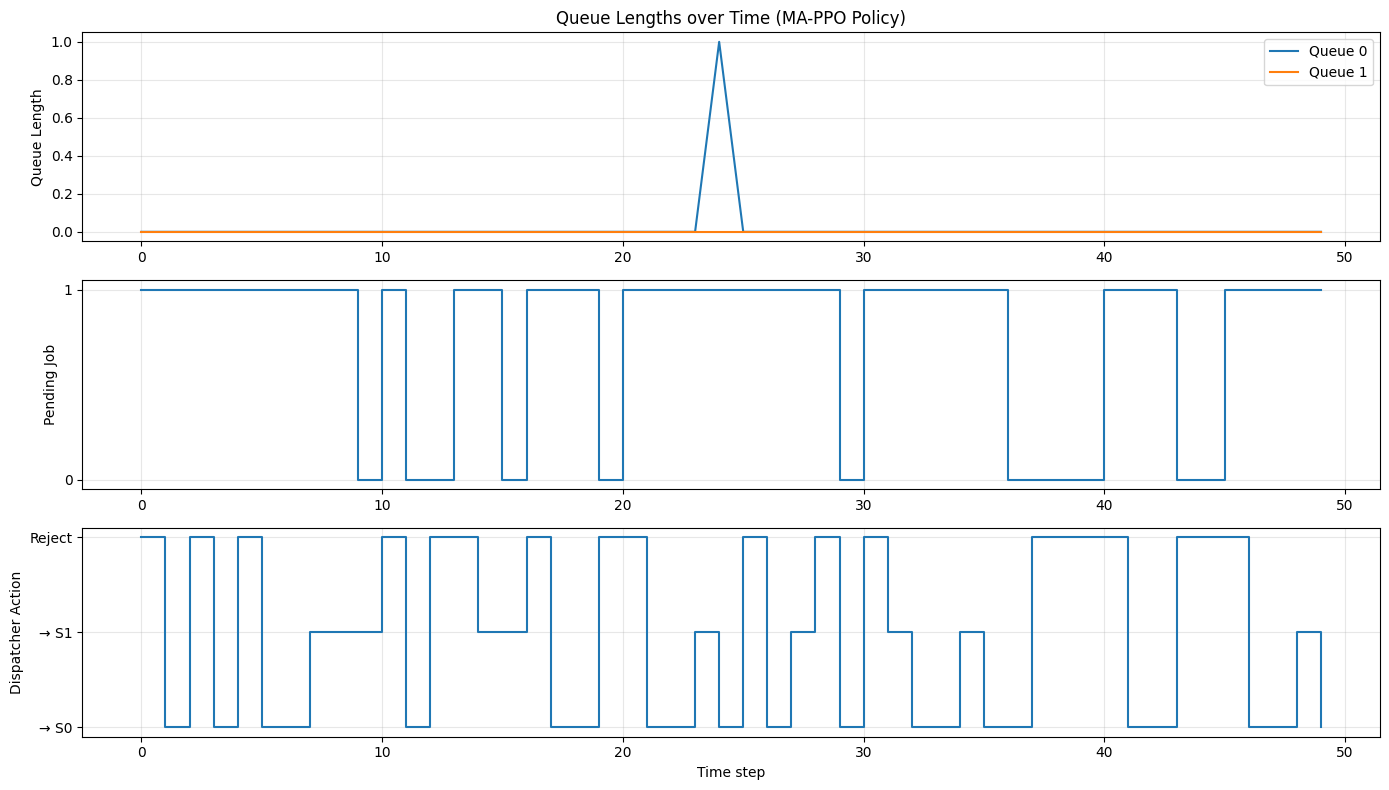

In [ ]:
def rollout_with_logging(env, ma_system, seed=123):
    obs, info = env.reset(seed=seed)
    logs = {
        "t": [],
        "q0": [],
        "q1": [],
        "pending": [],
        "disp_action": [],
        "acc0_action": [],
        "acc1_action": [],
        "reward": [],
    }

    for t in range(env.episode_length):
        mask = get_action_mask(env)
        (action_dict,
         disp_action, accept_actions,
         disp_log_prob, accept_log_probs, value) = ma_system.select_actions(obs, mask)

        next_obs, reward, terminated, truncated, info = env.step(action_dict)

        logs["t"].append(t)
        logs["q0"].append(len(env.station_queues[0]))
        logs["q1"].append(len(env.station_queues[1]))
        logs["pending"].append(1 if env.pending_job is not None else 0)
        logs["disp_action"].append(disp_action)
        logs["acc0_action"].append(action_dict["acceptor_0"])
        logs["acc1_action"].append(action_dict["acceptor_1"])
        logs["reward"].append(reward)

        obs = next_obs
        if terminated or truncated:
            break

    return logs

logs = rollout_with_logging(env_marl, ma_ppo, seed=999)

import matplotlib.pyplot as plt

t = logs["t"]

plt.figure(figsize=(14, 8))

# Queues
plt.subplot(3, 1, 1)
plt.plot(t, logs["q0"], label='Queue 0')
plt.plot(t, logs["q1"], label='Queue 1')
plt.ylabel('Queue Length')
plt.title('Queue Lengths over Time (MA-PPO Policy)')
plt.legend()
plt.grid(True, alpha=0.3)

# Pending flag
plt.subplot(3, 1, 2)
plt.step(t, logs["pending"], where='post')
plt.ylabel('Pending Job')
plt.yticks([0, 1])
plt.grid(True, alpha=0.3)

# Dispatcher action
plt.subplot(3, 1, 3)
plt.step(t, logs["disp_action"], where='post')
plt.ylabel('Dispatcher Action')
plt.yticks([0, 1, 2], ['→ S0', '→ S1', 'Reject'])
plt.xlabel('Time step')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import pickle

# ===== SAVE MA-PPO MODEL WEIGHTS =====
checkpoint_marl = {
    "dispatcher_actor_state_dict": ma_ppo.dispatcher_actor.state_dict(),
    "acceptor_actors_state_dict": [actor.state_dict() for actor in ma_ppo.acceptor_actors],
    "shared_critic_state_dict": ma_ppo.shared_critic.state_dict(),
    "optimizer_state_dict": ma_ppo.optimizer.state_dict(),
    "config": config_marl,
}

torch.save(checkpoint_marl, "marl_ppo_best.pth")
print("✓ Saved MA-PPO weights to marl_ppo_best.pth")

# ===== SAVE TRAINING METRICS =====
with open("marl_training_metrics.pkl", "wb") as f:
    pickle.dump(metrics_marl, f)

print("✓ Saved training metrics to marl_training_metrics.pkl")


✓ Saved MA-PPO weights to marl_ppo_best.pth
✓ Saved training metrics to marl_training_metrics.pkl


In [ ]:
from google.colab import files

files.download("marl_ppo_best.pth")
files.download("marl_training_metrics.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# REFERENCES

Primary Inspiration:
[1] Ali, A.M., Tirel, L., & Hashim, H.A. (2025). "Novel Multi-Agent Action Masked Deep Reinforcement Learning for General Industrial Assembly Lines Balancing Problems." Journal of Automation and Intelligence.

Core Algorithms:
[2] Mnih, V., et al. (2015). "Human-level control through deep reinforcement learning." Nature, 518(7540), 529-533. → DQN: Deep Q-Network
[3] Schulman, J., et al. (2017). "Proximal Policy Optimization Algorithms." arXiv:1707.06347. → PPO: Clipped surrogate objective
[4] Sutton, R.S. & Barto, A.G. (2018). "Reinforcement Learning: An Introduction." MIT Press. → Foundational RL concepts

Multi-Agent RL:
[5] Lowe, R., et al. (2017). "Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments." NeurIPS. → MADDPG: Centralized critic concept
[6] Yu, C., et al. (2022). "The Surprising Effectiveness of PPO in Cooperative Multi-Agent Games." NeurIPS. → MAPPO performance analysis

Tools & Libraries:
[7] Gymnasium (Farama Foundation) - https://gymnasium.farama.org/ → Environment API
[8] PyTorch - https://pytorch.org/ → Neural network implementation
[9] PettingZoo - https://pettingzoo.farama.org/ → Multi-agent environment benchmark

Course:
[10] CSE 546: Reinforcement Learning, Fall 2025 Instructor: Dr. Alina Vereshchaka University at Buffalo
